# Credit card fraud detection Kaggle dataset

* https://www.kaggle.com/mlg-ulb/creditcardfraud/version/3

Code which inspired this notebook:
* https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now
* http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/combine/plot_smote_enn.html#sphx-glr-auto-examples-combine-plot-smote-enn-py

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import pickle
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

#for logistic regression and over sampling
#cc = !nproc
cc = !sysctl -n hw.ncpu
cc = int(cc[0])

%matplotlib inline

In [2]:
# timing helper functions

def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")

In [ ]:
# set up parallel cluster using ipyparallel engines.
# ipcluster start
import ipyparallel as ipp
from ipyparallel import require
c = ipp.Client(profile='default')
v = c[:]
#print("engines running:",v)
print("engines running:",len(v))

## Load the data and clean it up

In [3]:
data = pd.read_csv("data/creditcard.csv")
data.shape

(284807, 31)

In [4]:
normamount = np.array(data['Amount'])
normamount = StandardScaler().fit_transform(normamount.reshape(-1,1))
data['normamount'] = normamount
del data['Amount']
del data['Time']
data = shuffle(data)
data.head(10)
data.shape

(284807, 30)

Elapsed time is 0.8128459453582764 seconds.


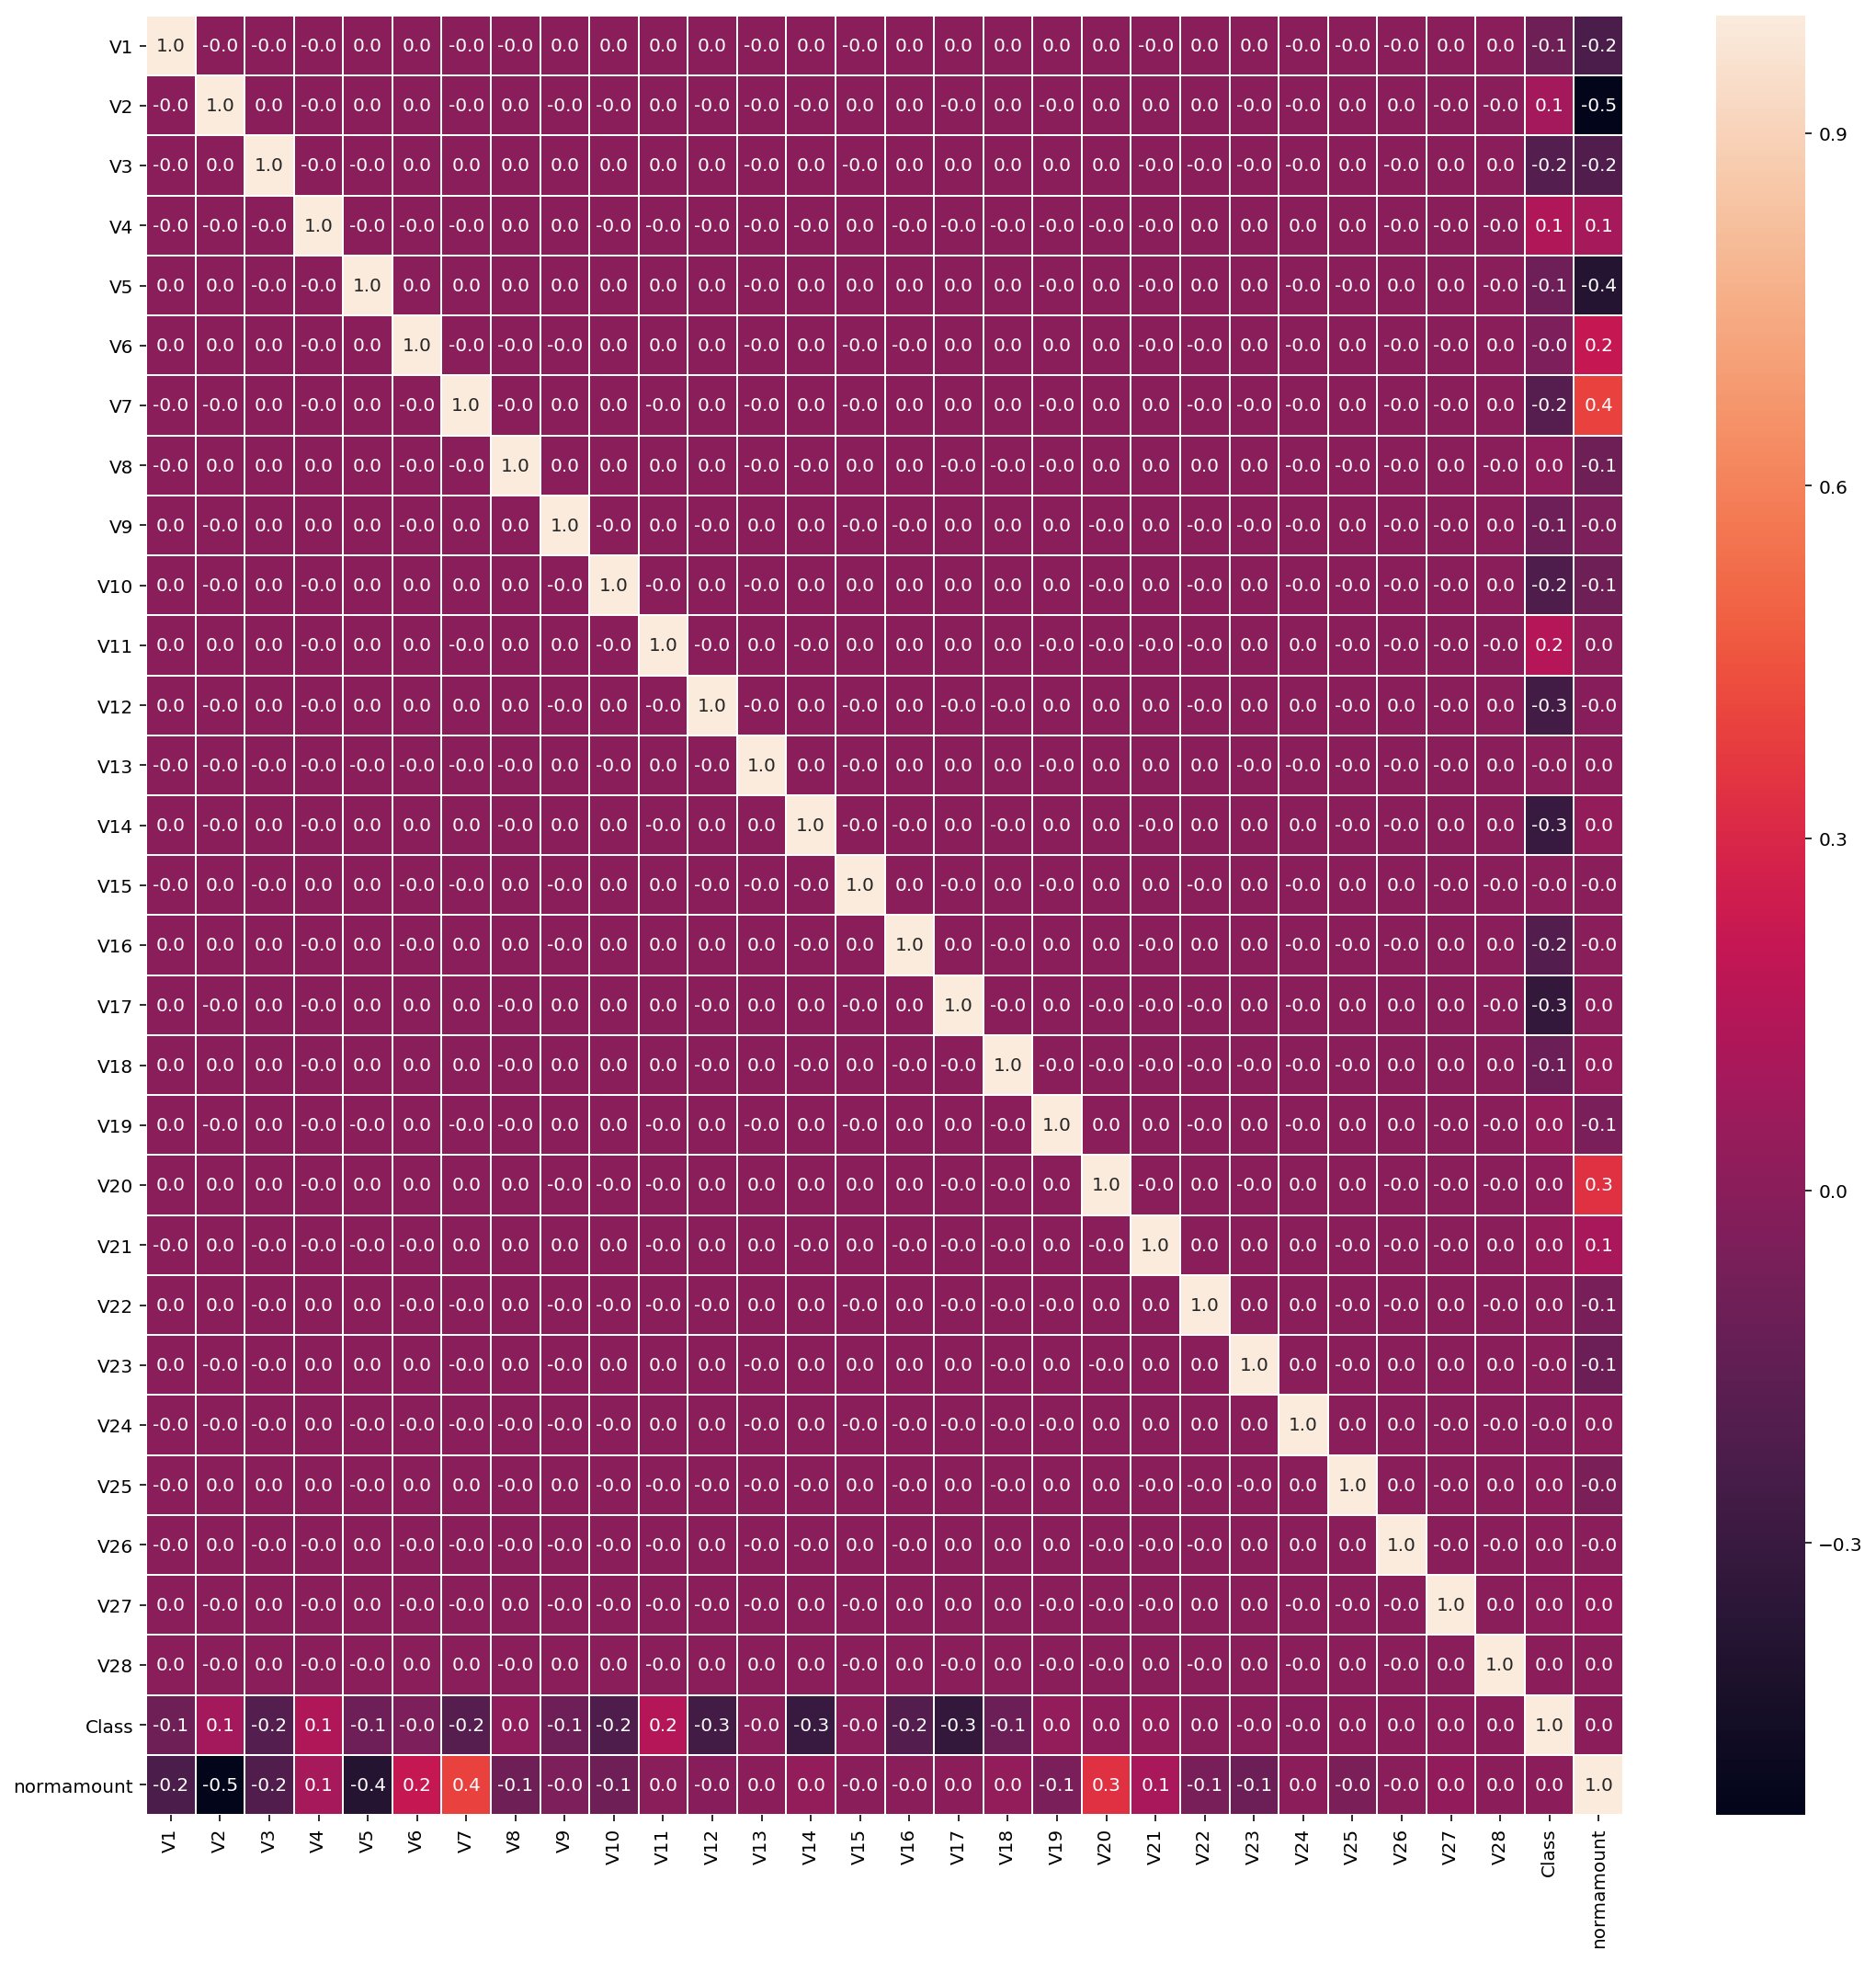

In [33]:
# heat map to look for correlation
tic()
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);
toc()

low correlation between features in this dataset.

In [35]:
#look at class imbalance
by_class = data.groupby('Class')
by_class.describe()

V1                                        V10       ...    V9  \
         count mean std   min  25%  50%  75% max    count mean  ...   75%   
Class                                                           ...         
0     284315.0  0.0 1.9 -56.4 -0.9  0.0  1.3 2.5 284315.0  0.0  ...   0.6   
1        492.0 -4.8 6.8 -30.6 -6.0 -2.3 -0.4 2.1    492.0 -5.7  ...  -0.8   

           normamount                                     
       max      count mean std  min  25%  50%  75%   max  
Class                                                     
0     15.6   284315.0 -0.0 1.0 -0.4 -0.3 -0.3 -0.0 102.4  
1      3.4      492.0  0.1 1.0 -0.4 -0.3 -0.3  0.1   8.1  

[2 rows x 232 columns]

The data appears to be quite heavily imbalanced as (obviously), fraudulent transactions should be relatively rare!

Can I use SMOTE over sampling to improve the balance of the data?

In [5]:
# http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.combine.SMOTEENN.html
# http://contrib.scikit-learn.org/imbalanced-learn/stable/combine.html#combine
from imblearn.over_sampling import ADASYN#SMOTE
sm = ADASYN(n_jobs=cc)

In [6]:
# split the features and target vector for resampling
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X)

In [8]:
X.columns = X.columns.astype(str)
y.columns = y.columns.astype(str)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

In [41]:
#resmaple just the training data and leave the test data untouched
tic()
#X_train_resampled, y_train_resampled = sm.fit_sample(X_train, y_train)
toc()
# this step takes a bit of time so I pickled the output

/Users/scheckley/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/scheckley/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Elapsed time is 1.869899034500122 seconds.


In [42]:
#pickle.dump(X_train_resampled, open( "X_train_resampled.pkl", "wb" ))
#pickle.dump(y_train_resampled, open( "y_train_resampled.pkl", "wb" ))

In [10]:
X_train_resampled = pickle.load(open( "X_train_resampled.pkl", "rb" ))
y_train_resampled = pickle.load(open( "y_train_resampled.pkl", "rb" ))

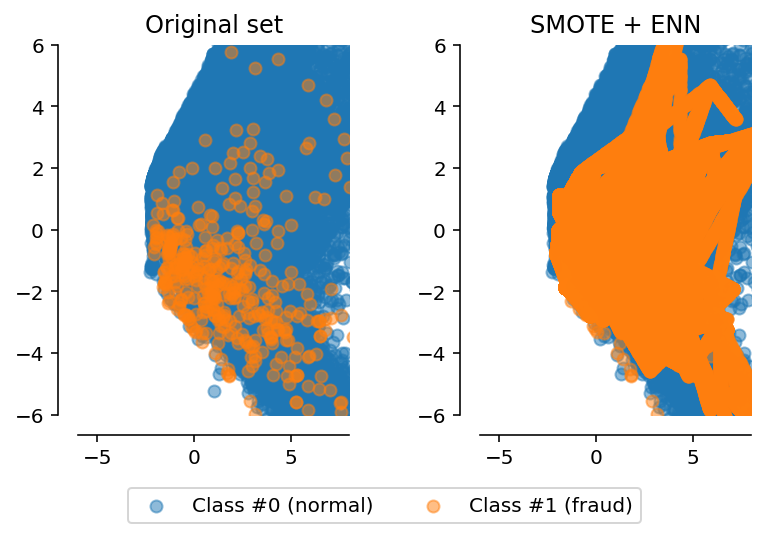

In [11]:
X_res_vis = pca.transform(X_train_resampled)

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2)

c0 = ax1.scatter(X_vis[y['Class'] == 0, 0], X_vis[y['Class'] == 0, 1], label="Class #0",
                 alpha=0.5)
c1 = ax1.scatter(X_vis[y['Class'] == 1, 0], X_vis[y['Class'] == 1, 1], label="Class #1",
                 alpha=0.5)
ax1.set_title('Original set')

ax2.scatter(X_res_vis[y_train_resampled == 0, 0], X_res_vis[y_train_resampled == 0, 1],
            label="Class #0", alpha=0.5)
ax2.scatter(X_res_vis[y_train_resampled == 1, 0], X_res_vis[y_train_resampled == 1, 1],
            label="Class #1", alpha=0.5)
ax2.set_title('SMOTE + ENN')

# make nice plotting
for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([-6, 8])
    ax.set_ylim([-6, 6])

f.legend((c0, c1), ('Class #0 (normal)', 'Class #1 (fraud)'), loc='lower center',
         ncol=2, labelspacing=0.)
plt.tight_layout(pad=3)
plt.show()

Prep the new resampled data for machine learning

In [18]:
#from sklearn.manifold import TSNE

In [166]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled,test_size = 0.3, random_state = 0)

In [40]:
#t-SNE
#model = TSNE(n_components=2, verbose=0, n_iter=300)
#t = model.fit_transform(X) #(X_resampled)

In [42]:
#pickle.dump(t, open( "tsne_model.pkl", "wb" ))

In [45]:
#t = pickle.load(open( "tsne_model.pkl", "rb" ))
#df_tsne = pd.DataFrame()
#df_tsne['x-tsne'] = t[:,0]
#df_tsne['y-tsne'] = t[:,1]
#df_tsne['target'] = y

#df_tsne2 = df_tsne.head(5000)

#colors = np.where(df_tsne.target > 0, 'r', 'b')

#df_tsne2.plot.scatter(x='x-tsne',y='y-tsne', c=colors,s=1)

In [21]:
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

In [22]:
#lr = LogisticRegression(C = 0.01, penalty = 'l1')
#lr.fit(X_train,y_train)
#y_pred = lr.predict(X_test)

In [23]:
# try a grid search to find best parameters
from sklearn.model_selection import GridSearchCV
tic()
lr = LogisticRegression(C = 0.01, penalty = 'l1')# , solver='liblinear')
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}#[0.001,0.01,0.1,1,10,100]}
lr = GridSearchCV(lr, param_grid=grid_values, n_jobs=cc)
lr.fit(X_train_resampled,y_train_resampled)
print(lr.best_params_)

y_pred = lr.predict(X_test)
toc()

{'C': 0.01, 'penalty': 'l2'}
Elapsed time is 412.21172189712524 seconds.


In [134]:
#lr_best = LogisticRegression(C=lr.best_params_['C'], penalty=lr.best_params_['penalty'], solver='lbfgs', n_jobs=cc)
#lr_best.fit(X_train, y_train)
#y_pred = lr_best.predict(X_test)

In [24]:
# confusion matrix plotting function
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the testing dataset:  0.9415584415584416


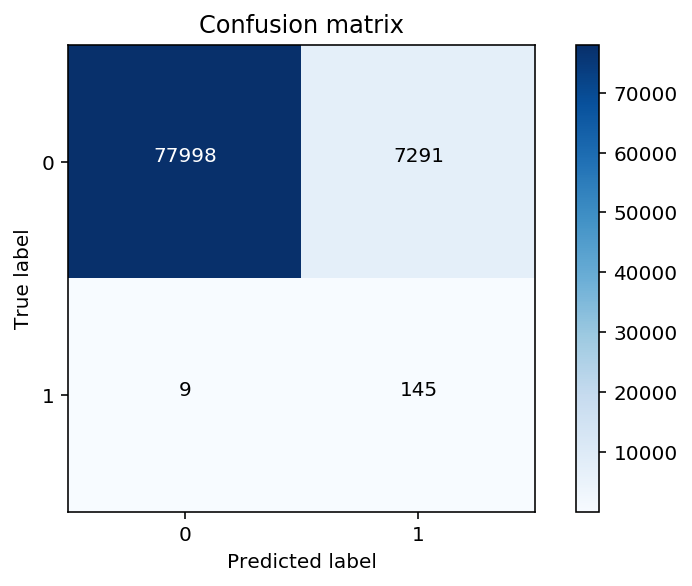

In [25]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

# best recall metric = 0.915, with C=0.01
# improved to 0.919 with gridsearch finding l2 penalty and C=10.

/Users/scheckley/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


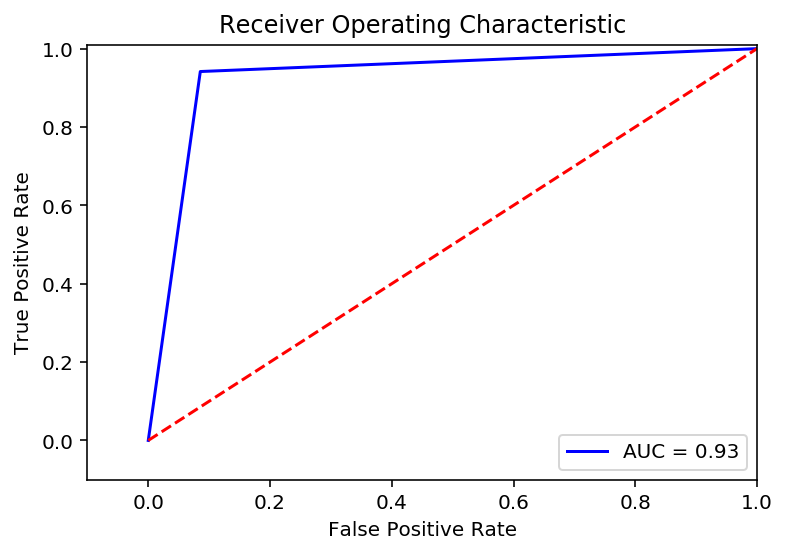

In [26]:
# ROC curve
lr = LogisticRegression(C = 10, penalty = 'l2')
y_pred_score = lr.fit(X_train,y_train).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# try a grid search to find best parameters
from sklearn.model_selection import GridSearchCV
tic()
rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=4)
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
rf = GridSearchCV(rf, param_grid=grid_values, n_jobs=cc)
rf.fit(X_train_resampled,y_train_resampled)
print(rf.best_params_)

y_pred = rf.predict(X_test)
toc()

In [ ]:
# ROC curve
#lr = LogisticRegression(C = 10, penalty = 'l2')
y_pred_score = rf.fit(X_train,y_train).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Tensor flow - 'cos everybody loves a neural network!

In [45]:
import tensorflow as tf
import tensorflow.contrib.learn as skflow
from tensorflow.python.data import Dataset
from sklearn import metrics
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

In [46]:
X_resampled = pickle.load(open( "X_resampled.pkl", "rb" ))
y_resampled = pickle.load(open( "y_resampled.pkl", "rb" ))

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled,test_size = 0.3, random_state = 0)

In [63]:
X_train = shuffle(X_train)
X_test = shuffle(X_test)

inputX = np.asmatrix(X_train)
inputY = np.rot90(np.asmatrix(y_train))
inputX_test = np.asmatrix(X_test)
inputY_test = np.rot90(np.asmatrix(y_test))

inputX.shape, inputY.shape, inputX_test.shape, inputY_test.shape

((397741, 29), (397741, 1), (170461, 29), (170461, 1))

In [64]:
my_features = pd.DataFrame(X_resampled)
targets = pd.DataFrame(y_resampled)

my_features.columns = my_features.columns.astype(str)
targets.columns = targets.columns.astype(str)

In [65]:
# little script to automatically assign feature columns for Tensorflow as strings or ints.
import pandas.api.types as ptypes

my_columns = []

for col in my_features.columns:
  if ptypes.is_string_dtype(my_features[col]): #is_string_dtype is pandas function
    my_columns.append(tf.feature_column.categorical_column_with_hash_bucket(col, 
        hash_bucket_size= len(my_features[col].unique())))

  elif ptypes.is_numeric_dtype(my_features[col]): #is_numeric_dtype is pandas function
    my_columns.append(tf.feature_column.numeric_column(col))

In [66]:
feature_columns = my_columns

In [67]:
my_features.shape, targets.shape

((568202, 29), (568202, 1))

In [68]:
#Multiplier maintains a fixed ratio of nodes between each layer
mulitplier = 1.5 

#Number of nodes in hidden layer 1
hidden_nodes1 = 15
hidden_nodes2 = round(hidden_nodes1 * mulitplier)
hidden_nodes3 = round(hidden_nodes2 * mulitplier)

#input
x = tf.placeholder(tf.float32, [None, 29]) #there are 29 inputs

In [69]:
#layer 1
W1 = tf.Variable(tf.zeros([29, hidden_nodes1]))
b1 = tf.Variable(tf.zeros([hidden_nodes1]))
y1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)

#layer 2
W2 = tf.Variable(tf.zeros([hidden_nodes1, hidden_nodes2]))
b2 = tf.Variable(tf.zeros([hidden_nodes2]))
y2 = tf.nn.sigmoid(tf.matmul(y1, W2) + b2)

#layer 3
W3 = tf.Variable(tf.zeros([hidden_nodes2, hidden_nodes3])) 
b3 = tf.Variable(tf.zeros([hidden_nodes3]))
y3 = tf.nn.sigmoid(tf.matmul(y2, W3) + b3)

#layer 4
W4 = tf.Variable(tf.zeros([hidden_nodes3, 2])) 
b4 = tf.Variable(tf.zeros([2]))
y4 = tf.nn.softmax(tf.matmul(y3, W4) + b4)

#output
y = y4
y_ = tf.placeholder(tf.float32, [None, 1])

In [70]:
#Parameters
learning_rate = 0.0005
training_epochs = 100  #Use 30000; it is set to 100 to load faster onto Kaggle
display_step = 100
n_samples = y_train.size

In [71]:
#Cost function: Mean squared error
cost = tf.reduce_sum(tf.pow(y_ - y, 2))/(2*n_samples)

#We will optimize our model via AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

#Correct prediction if the most likely value (Fraud or Normal) from softmax equal the target value
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [72]:
#Initialize variables and tensorflow session
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [73]:
accuracy_summary = [] #Record accuracy values for plot
cost_summary = [] #Record cost values for plot

for i in range(training_epochs):  
    sess.run([optimizer], feed_dict={x: inputX, y_: inputY})
    
    # Display logs per epoch step
    if (i) % display_step == 0:
        train_accuracy, newCost = sess.run([accuracy, cost], feed_dict={x: inputX, y_: inputY})
        print ("Training step:", i,
               "Accuracy =", "{:.5f}".format(train_accuracy), 
               "Cost = ", "{:.5f}".format(newCost))
        accuracy_summary.append(train_accuracy)
        cost_summary.append(newCost)
        
print()
print ("Optimization Finished!")
training_accuracy = sess.run(accuracy, feed_dict={x: inputX, y_: inputY})
print ("Training Accuracy=", training_accuracy)
print()
testing_accuracy = sess.run(accuracy, feed_dict={x: inputX_test, y_: inputY_test})
print ("Testing Accuracy=", testing_accuracy)

Training step: 0 Accuracy = 1.00000 Cost =  0.25000

Optimization Finished!
Training Accuracy= 1.0

Testing Accuracy= 1.0


In [74]:
#Use to find testing accuracy if I interrupt the training before it is finished
predicted = tf.argmax(y, 1)
testing_accuracy, testing_predictions = sess.run([accuracy,predicted], feed_dict={x: inputX_test, y_: inputY_test })
print(testing_accuracy)

1.0


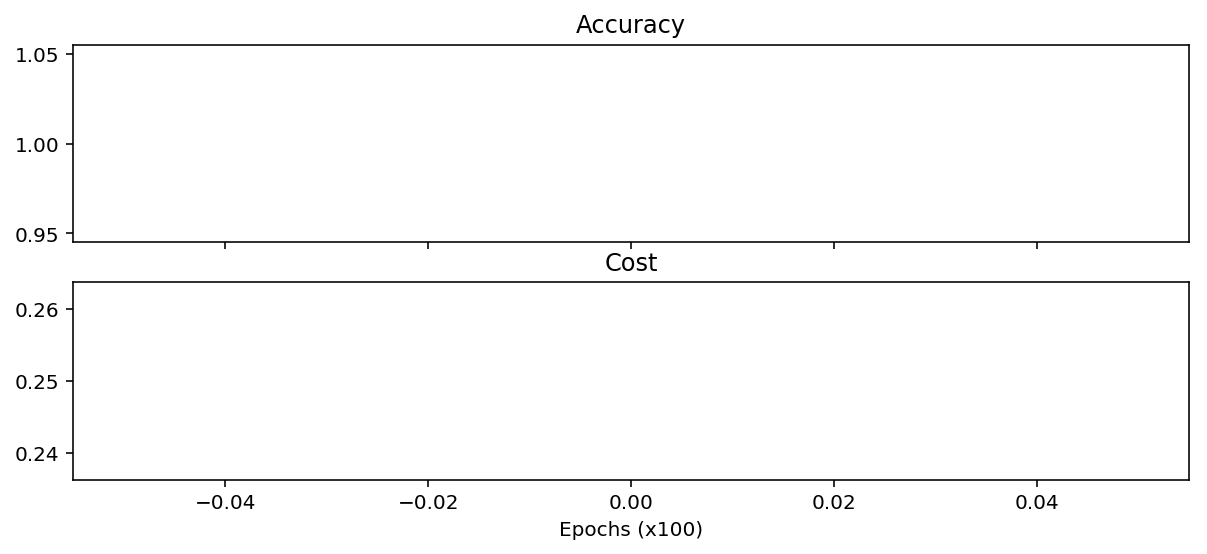

In [75]:
#Plot accuracy and cost summary

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,4))

ax1.plot(accuracy_summary)
ax1.set_title('Accuracy')

ax2.plot(cost_summary)
ax2.set_title('Cost')

plt.xlabel('Epochs (x100)')
plt.show()


In [76]:
confusion_matrix(y_test.Normal, testing_predictions)

AttributeError: 'numpy.ndarray' object has no attribute 'Normal'